<a href="https://colab.research.google.com/github/hallinearaujo/array_girls/blob/main/pratica_LDA_data_set_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import linalg

%matplotlib inline
pd.options.display.max_rows = 10

In [3]:
iris = load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [5]:
#df.drop elimina a ultima coluna deixando o dataset somente com 4 colunas: dois tipos de cepa e dois tipos de petalas
x = df.drop(labels='class', axis=1).values
y = df['class'].values

print(x.shape, y.shape)

(150, 4) (150,)


In [6]:
#quando nao tem biblioteca e quer implementar o codigo na mão
class LDA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.priors_ = None
        self.means_ = []
        self.covariance_ = []
        self.overall_mean = 0.0
        self.eigen_values = None
        self.eigen_vectors = None

    def fit(self, x, y):
        classes = np.unique(y)
        n_classes = len(classes)
        _, n_features = x.shape
        self.priors_ = np.bincount(y) / float(len(y))
        self.max_components = n_classes - 1 if self.n_components is None else np.clip(self.n_components, 1, n_classes - 1)

        # Passo 1: calcular os vetores médios para cada classe
        self.means_ = np.array([np.mean(x[y == c], axis=0) for c in classes])

        # Passo 2: calcular as scatter matrices
        self.covariance_ = np.sum([p * np.cov(x[y == c], rowvar=False, bias=1) for p, c in zip(self.priors_, classes)], axis=0)
        S_w = self.covariance_
        S_t = np.cov(x.T, bias=1)
        S_b = S_t - S_w

        # Passo 3: calcular os autovalores e autovetores
        self.eigen_values, self.eigen_vectors = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
        self.eigen_vectors *= -1

        # Passo 4: seleção dos discriminantes lineares
        self.sorted_components_ = np.argsort(self.eigen_values)[::-1]

        self.projection_matrix_ = self.eigen_vectors[:, self.sorted_components_[:self.max_components]]

        self.explained_variance_ = self.eigen_values[self.sorted_components_]
        self.explained_variance_ratio_ = self.explained_variance_ / self.eigen_values.sum()

    def predict(self, x):
        cov_inv = np.linalg.inv(self.covariance_)

        discriminants = []
        for p, mean_vec in zip(self.priors_, self.means_):
            first_term = np.dot(x, cov_inv).dot(mean_vec.T).reshape(-1, 1)
            second_term = 0.5 * (np.dot(mean_vec, cov_inv).dot(mean_vec.T))
            discriminants.append(first_term - second_term + np.log(p))

        discriminants = np.hstack(discriminants)
        return np.argmax(discriminants, axis=1)

    def transform(self, x):
        return np.dot(x, self.projection_matrix_)

In [7]:
lda = LDA()
lda.fit(x, y)

print(lda.means_)
print(lda.covariance_)
print(lda.eigen_vectors)
print(lda.explained_variance_ratio_)

[[5.006 3.428 1.462 0.246]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]
[[0.259708   0.09086667 0.164164   0.03763333]
 [0.09086667 0.11308    0.05413867 0.032056  ]
 [0.164164   0.05413867 0.181484   0.041812  ]
 [0.03763333 0.032056   0.041812   0.041044  ]]
[[ 0.20874182  0.00653196  0.79545141 -0.38088852]
 [ 0.38620369  0.58661055 -0.11399897  0.42914595]
 [-0.55401172 -0.25256154 -0.06274054  0.48285993]
 [-0.7073504   0.76945309 -0.59188251 -0.66151642]]
[ 9.91212605e-01  8.78739503e-03  6.12340434e-16 -1.58906111e-16]


In [8]:
x_proj = lda.transform(x)
y_pred = lda.predict(x[::15])

print(x_proj[:5])
print(y_pred)

[[1.49920971 1.88675441]
 [1.2643595  1.59214275]
 [1.35525305 1.73341462]
 [1.18495616 1.62358806]
 [1.5169559  1.94476227]]
[0 0 0 0 1 1 1 2 2 2]


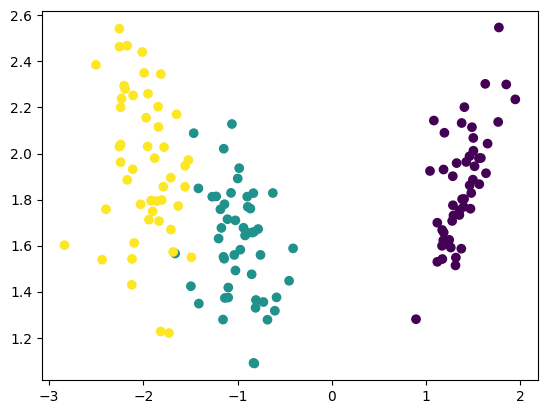

In [12]:
#plotar o grafico com caracteristicas separadas com dados mais unificados garantindo eliminação do overfitting, melhora a qualidade das infos
#trabalhadas no modelo
plt.scatter(x_proj[:, 0], x_proj[:, 1], c=y)

In [13]:
lda_sk = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
lda_sk.fit(x, y)

print(lda_sk.means_)
print(lda_sk.covariance_)
print(lda_sk.scalings_)
print(lda_sk.explained_variance_ratio_)

[[5.006 3.428 1.462 0.246]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]
[[0.259708   0.09086667 0.164164   0.03763333]
 [0.09086667 0.11308    0.05413867 0.032056  ]
 [0.164164   0.05413867 0.181484   0.041812  ]
 [0.03763333 0.032056   0.041812   0.041044  ]]
[[ 0.83779794  0.02434685  2.25563992 -2.29660737]
 [ 1.55005187  2.18649663 -2.68832574  0.33740599]
 [-2.22355955 -0.94138258 -3.03711552  0.19114203]
 [-2.83899363  2.86801283  4.28813496  1.68800241]]
[0.9912126 0.0087874]


In [14]:
#faz a transformação e predição
x_proj_sk = lda_sk.transform(x)
y_pred_sk = lda_sk.predict(x[::15])

print(x_proj_sk[:5])
print(y_pred_sk)

[[6.01716893 7.03257409]
 [5.0745834  5.9344564 ]
 [5.43939015 6.46102462]
 [4.75589325 6.05166375]
 [6.08839432 7.24878907]]
[0 0 0 0 1 1 1 2 2 2]


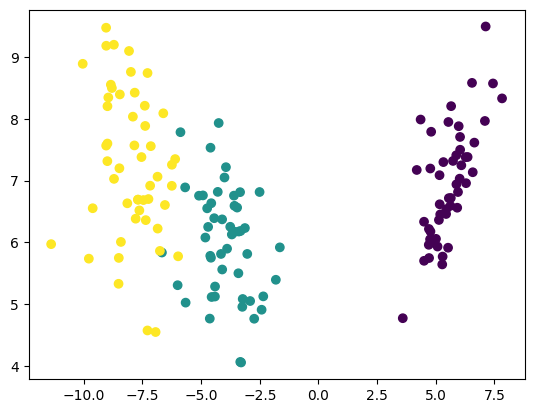

In [16]:
#plota o novo grafico
plt.scatter(x_proj_sk[:, 0], x_proj_sk[:, 1], c=y)